In [46]:
import numpy as np

def create_distance_matrix(coordinates):
    """Create a distance matrix from 3D coordinates."""
    n_atoms = coordinates.shape[0]
    distance_matrix = np.zeros((n_atoms, n_atoms))
    
    for i in range(n_atoms):
        for j in range(i+1, n_atoms):
            distance = np.sqrt(np.sum((coordinates[i] - coordinates[j])**2))
            distance_matrix[i,j] = distance
            distance_matrix[j,i] = distance
            
    return distance_matrix

def get_eigendecomposition(distance_matrix):
    """
    Calculate eigenvalues and eigenvectors of the distance matrix.
    Returns sorted eigenvalues and corresponding eigenvectors.
    """
    eigenvalues, eigenvectors = np.linalg.eigh(distance_matrix)
    # Sort by eigenvalues in descending order
    idx = eigenvalues.argsort()[::-1]
    return eigenvalues[idx], eigenvectors[:, idx]

def spectral_similarity(coords1, coords2):
    """
    Compare conformers using both eigenvalues and eigenvector information.
    This might better capture local symmetries.
    """
    dist_mat1 = create_distance_matrix(coords1)
    dist_mat2 = create_distance_matrix(coords2)
    
    evals1, evecs1 = get_eigendecomposition(dist_mat1)
    evals2, evecs2 = get_eigendecomposition(dist_mat2)
    
    # Several possible metrics:
    
    # 1. Weighted eigenvalue difference
    # Give more weight to larger eigenvalues
    weights = np.exp(-np.arange(len(evals1)) / 2)  # Exponential decay weights
    weighted_eval_diff = np.sqrt(np.mean(weights * (evals1 - evals2)**2))
    
    # 2. Eigenvector correlation
    # Compare the principal eigenvectors (first few that capture most variance)
    n_principal = 3  # Number of principal components to consider
    vector_correlation = 0
    for i in range(n_principal):
        corr = np.abs(np.dot(evecs1[:, i], evecs2[:, i]))
        vector_correlation += corr
    vector_correlation /= n_principal
    
    # 3. Spectral overlap (using both eigenvalues and vectors)
    spectral_overlap = 0
    for i in range(len(evals1)):
        for j in range(len(evals2)):
            overlap = np.abs(np.dot(evecs1[:, i], evecs2[:, j]))
            spectral_overlap += overlap * np.exp(-abs(evals1[i] - evals2[j]))
    spectral_overlap /= len(evals1)
    
    return {
        'weighted_eval_diff': weighted_eval_diff,
        'vector_correlation': vector_correlation,
        'spectral_overlap': spectral_overlap
    }

def weighted_eval_diff_v1(evals1, evals2):
    """Original weighted eigenvalue difference."""
    weights = np.exp(-np.arange(len(evals1)) / 2)
    return np.sqrt(np.mean(weights * (evals1 - evals2)**2))

def weighted_eval_diff_v2(evals1, evals2):
    """
    Modified version focusing on largest eigenvalues.
    Uses sharper exponential decay to focus more on dominant eigenvalues.
    """
    weights = np.exp(-np.arange(len(evals1)))  # Sharper decay
    return np.sqrt(np.mean(weights * (evals1 - evals2)**2))

def weighted_eval_diff_v3(evals1, evals2):
    """
    Version using only top N eigenvalues with equal weights.
    This might reduce noise from less significant eigenvalues.
    """
    n_top = 5  # Consider only top 5 eigenvalues
    return np.sqrt(np.mean((evals1[:n_top] - evals2[:n_top])**2))

def weighted_eval_diff_v4(evals1, evals2):
    """
    Version using ratios between consecutive eigenvalues.
    This might better capture relative changes in structure.
    """
    ratios1 = evals1[:-1] / evals1[1:]
    ratios2 = evals2[:-1] / evals2[1:]
    weights = np.exp(-np.arange(len(ratios1)) / 2)
    return np.sqrt(np.mean(weights * (ratios1 - ratios2)**2))

def weighted_eval_diff_v5(evals1, evals2):
    """
    Version using logarithmic differences of eigenvalues.
    This might better handle the scale differences between eigenvalues.
    """
    log_diff = np.log(np.abs(evals1)) - np.log(np.abs(evals2))
    weights = np.exp(-np.arange(len(evals1)) / 2)
    return np.sqrt(np.mean(weights * log_diff**2))

def compare_conformers(coords1, coords2, atomnos):
    """Compare conformers using all metrics."""

    coords1 = coords1[atomnos != 1]
    coords2 = coords2[atomnos != 1]

    dist_mat1 = create_distance_matrix(coords1)
    dist_mat2 = create_distance_matrix(coords2)
    
    evals1 = get_eigendecomposition(dist_mat1)[0]
    evals2 = get_eigendecomposition(dist_mat2)[0]
    
    return {
        'v1_standard': weighted_eval_diff_v1(evals1, evals2),
        'v2_sharp_decay': weighted_eval_diff_v2(evals1, evals2),
        'v3_top_n': weighted_eval_diff_v3(evals1, evals2),
        'v4_ratios': weighted_eval_diff_v4(evals1, evals2),
        'v5_log_diff': weighted_eval_diff_v5(evals1, evals2)
    }

In [39]:
from firecode.utils import read_xyz, graphize
import matplotlib.pyplot as plt
from firecode.rmsd import rmsd_and_max_numba
from firecode.pruning import rotationally_corrected_rmsd_and_max, _get_torsions

mol = read_xyz('/home/Coding/RightRMSD/tBuPh_scan.xyz')
coords = mol.atomcoords

x = [10*i for i, _ in enumerate(coords)]
rmsd_y = [rmsd_and_max_numba(coords[0], c, center=True)[0] for c in coords]

graph = graphize(coords[0], mol.atomnos)
torsions = _get_torsions(graph, [], [], keepdummy=True, mode="csearch")
torsions = [torsions[2]]
rot_corr_rmsd = normalize([rotationally_corrected_rmsd_and_max(
    coords[0],
    c,
    mol.atomnos,
    torsions=[np.array(t.torsion) for t in torsions],
    graph=graph,
    angles=[t.get_angles() for t in torsions],
)[0] for c in coords])




In [33]:
def normalize(l):
    return np.array(l)/np.max(l)

In [38]:
k = 20
sp_sim = [spectral_similarity(coords[0], c) for c in coords]
sp_sim1 = normalize([s["weighted_eval_diff"]*k for s in sp_sim])

In [48]:
res = [compare_conformers(coords[0], c, mol.atomnos) for c in coords]
v1 = normalize([s["v1_standard"]*k for s in res])
v2 = normalize([s["v2_sharp_decay"]*k for s in res])
v3 = normalize([s["v3_top_n"]*k for s in res])
v4 = normalize([s["v4_ratios"]*k for s in res])
v5 = normalize([s["v5_log_diff"]*k for s in res])

In [49]:
print('RMSD vs rot.corr.')
print(f's1 - {round(np.sqrt(np.mean((sp_sim1 - rot_corr_rmsd)**2)), 2)}')
print(f'v1 - {round(np.sqrt(np.mean((v1 - rot_corr_rmsd)**2)), 2)}')
print(f'v2 - {round(np.sqrt(np.mean((v2 - rot_corr_rmsd)**2)), 2)}')
print(f'v3 - {round(np.sqrt(np.mean((v3 - rot_corr_rmsd)**2)), 2)}')
print(f'v4 - {round(np.sqrt(np.mean((v4 - rot_corr_rmsd)**2)), 2)}')
print(f'v5 - {round(np.sqrt(np.mean((v5 - rot_corr_rmsd)**2)), 2)}')
print(f'rand - {round(np.sqrt(np.mean((np.random.rand(len(rot_corr_rmsd)) - rot_corr_rmsd)**2)), 2)}')

RMSD vs rot.corr.
s1 - 0.36
v1 - 0.34
v2 - 0.35
v3 - 0.35
v4 - 0.36
v5 - 0.32
rand - 0.46


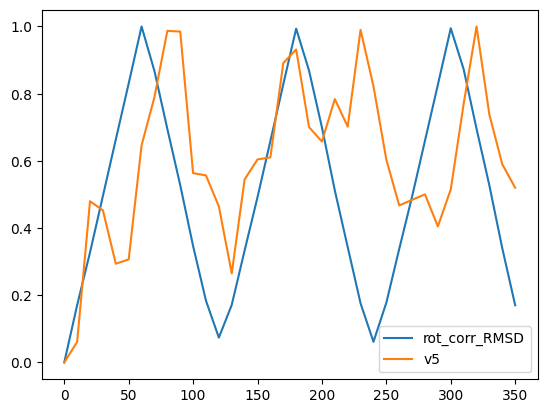

In [51]:

fig = plt.figure()
# plot = plt.plot(x, rmsd_y, label='RMSD')
plot = plt.plot(x, rot_corr_rmsd, label='rot_corr_RMSD')
# plot = plt.plot(x, sp_sim1, label=f'sp_sim1')
# plot = plt.plot(x, v1, label=f'v1')
# plot = plt.plot(x, v2, label=f'v2')
# plot = plt.plot(x, v3, label=f'v3')
# plot = plt.plot(x, v4, label=f'v4')
plot = plt.plot(x, v5, label=f'v5')
plt.legend()

In [62]:
from scipy.special import sph_harm

def get_spherical_coords(xyz):
    """Convert Cartesian to spherical coordinates (r, theta, phi)."""
    x, y, z = xyz.T
    r = np.sqrt(x**2 + y**2 + z**2)
    theta = np.arccos(z/r, where=r != 0)  # polar angle
    phi = np.arctan2(y, x)  # azimuthal angle
    return r, theta, phi

def molecular_spherical_descriptor(coordinates, max_l=4, weighted=True):
    """
    Create a rotation-invariant molecular descriptor using spherical harmonics.
    
    Parameters:
    coordinates: np.array of shape (n_atoms, 3) with XYZ coordinates
    max_l: maximum angular momentum quantum number
    weighted: whether to weight by distance from center of mass
    
    Returns:
    descriptor: array of rotation-invariant features
    """
    # Center coordinates on center of mass
    # com = coordinates.mean(axis=0)
    com = coordinates[1]
    coords = coordinates - com
    
    # Get spherical coordinates
    r, theta, phi = get_spherical_coords(coords)
    
    # Initialize descriptor
    descriptor = []
    
    # For each l, compute power spectrum
    for l in range(max_l + 1):
        power = 0
        for m in range(-l, l+1):
            # Compute spherical harmonics for all points
            Ylm = sph_harm(m, l, phi, theta)
            
            if weighted:
                # Weight by radial function (here using simple r-weighting)
                coeff = np.sum(Ylm * r)
            else:
                coeff = np.sum(Ylm)
            
            # Add to power for this l
            power += np.abs(coeff)**2
            
        descriptor.append(power)
    
    return np.array(descriptor)

def compare_conformers_sh(coords1, coords2, max_l=4):
    """
    Compare two conformers using spherical harmonic descriptors.
    Returns a similarity metric that should show periodicity for symmetric rotations.
    """
    desc1 = molecular_spherical_descriptor(coords1, max_l)
    desc2 = molecular_spherical_descriptor(coords2, max_l)
    
    # Compute similarity (could try different metrics here)
    # Using relative differences to handle different scales of components
    relative_diff = np.abs(desc1 - desc2) / (np.abs(desc1) + np.abs(desc2) + 1e-10)
    
    # Weight higher l components more as they capture finer details
    weights = np.arange(1, len(relative_diff) + 1)**2
    
    return np.sum(weights * relative_diff)

sh1 = normalize([compare_conformers_sh(coords[0][mol.atomnos!=1], c[mol.atomnos!=1], max_l=1) for c in coords])
sh2 = normalize([compare_conformers_sh(coords[0][mol.atomnos!=1], c[mol.atomnos!=1], max_l=2) for c in coords])
sh3 = normalize([compare_conformers_sh(coords[0][mol.atomnos!=1], c[mol.atomnos!=1], max_l=3) for c in coords])
sh4 = normalize([compare_conformers_sh(coords[0][mol.atomnos!=1], c[mol.atomnos!=1], max_l=4) for c in coords])
sh5 = normalize([compare_conformers_sh(coords[0][mol.atomnos!=1], c[mol.atomnos!=1], max_l=5) for c in coords])


/tmp/ipykernel_463305/1368939858.py:7: RuntimeWarning: invalid value encountered in true_divide
  theta = np.arccos(z/r, where=r != 0)  # polar angle


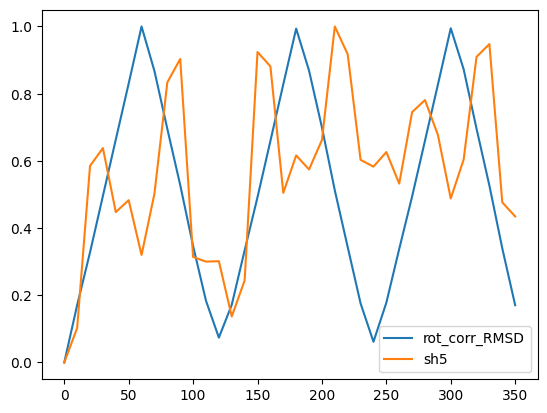

In [64]:

fig = plt.figure()
plot = plt.plot(x, rot_corr_rmsd, label='rot_corr_RMSD')
# plot = plt.plot(x, sh1, label=f'sh1')
# plot = plt.plot(x, sh2, label=f'sh2')
# plot = plt.plot(x, sh3, label=f'sh3')
# plot = plt.plot(x, sh4, label=f'sh4')
plot = plt.plot(x, sh5, label=f'sh5')
plt.legend()

In [63]:
print('RMSD vs rot.corr.')
print(f's1 - {round(np.sqrt(np.mean((sp_sim1 - rot_corr_rmsd)**2)), 2)}')
print(f'sh1 - {round(np.sqrt(np.mean((sh1 - rot_corr_rmsd)**2)), 2)}')
print(f'sh2 - {round(np.sqrt(np.mean((sh2 - rot_corr_rmsd)**2)), 2)}')
print(f'sh3 - {round(np.sqrt(np.mean((sh3 - rot_corr_rmsd)**2)), 2)}')
print(f'sh4 - {round(np.sqrt(np.mean((sh4 - rot_corr_rmsd)**2)), 2)}')
print(f'sh5 - {round(np.sqrt(np.mean((sh5 - rot_corr_rmsd)**2)), 2)}')
print(f'rand - {round(np.sqrt(np.mean((np.random.rand(len(rot_corr_rmsd)) - rot_corr_rmsd)**2)), 2)}')

RMSD vs rot.corr.
s1 - 0.36
sh1 - 0.37
sh2 - 0.33
sh3 - 0.35
sh4 - 0.32
sh5 - 0.32
rand - 0.44
